In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
log_df = pd.read_csv('../../datasets/citilink_task/log.csv',sep='\t')
named_df = pd.read_csv('../../datasets/citilink_task/named.csv',sep='\t')
type_contract_df = pd.read_csv('../../datasets/citilink_task/type_contract.csv',sep=';')
train_df = pd.read_csv('../../datasets/citilink_task/train.csv',sep=';')
test_df = pd.read_csv('../../datasets/citilink_task/test.csv',sep=';')

## Действия клиентов

In [3]:
log_df.head()

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета
4,36294,2021-03-28 16:31:17,"Включение услуги ""Ограничение функций ТВ"""


In [4]:
len(log_df['event_type'].unique())

113

In [5]:
log_df.shape

(26431, 3)

## Обращения клиентов к доменам конкурентов

In [6]:
named_df.head()

,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335
3,17-Apr-2021,tvip-provision.sampo.ru,61670
4,17-Apr-2021,tvip-provision.sampo.ru,39370


In [7]:
named_df.shape

(10646537, 3)

In [8]:

len(named_df['url'].unique())

6583

## Тип списания у клиентов

In [9]:
type_contract_df.head()

,contract_id,day_or_month_contract
0,7780,0
1,7784,0
2,7785,0
3,7794,0
4,7795,1


In [10]:
train_df.head()

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0
3,7795,0
4,7798,0


In [11]:
train_df.drop_duplicates(subset=['contract_id']).shape[0], test_df.drop_duplicates(subset=['contract_id']).shape[0]

(5992, 810)

In [12]:
train_df.drop_duplicates(subset=['contract_id']).shape[0] +  test_df.drop_duplicates(subset=['contract_id']).shape[0]

6802

## для начала надо понять сколько первых дней взять для прогноза 

In [13]:
log_df['event_date'] = pd.to_datetime(log_df['event_date'])
named_df['date'] = pd.to_datetime(named_df['date'])


Text(0, 0.5, 'кол. клиентов')

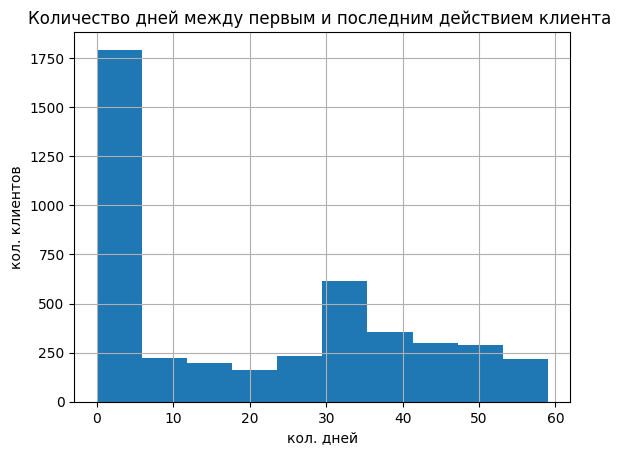

In [14]:
first_event_client = log_df.groupby('contract_id',as_index=False)\
                                .agg({'event_date':'min'})\
                                .rename(columns={'event_date':'first_event'})

last_event_client = log_df.groupby('contract_id',as_index=False)\
                                .agg({'event_date':'max'})\
                                .rename(columns={'event_date':'last_event'})


first_and_last_event = first_event_client.merge(last_event_client,on='contract_id')

diff_event = (first_and_last_event['last_event'] - first_and_last_event['first_event']).dt.days

diff_event.hist()

plt.title('Количество дней между первым и последним действием клиента ')
plt.xlabel('кол. дней')
plt.ylabel('кол. клиентов')

### глядя на график можно сделать вывод что первых 10 дней будет достаточно 

In [15]:
count_days = 10

In [16]:
log_df = log_df.merge(first_event_client ,on='contract_id',how='outer')
log_df = log_df.merge(last_event_client ,on='contract_id',how='outer')


mask = (log_df['event_date'] - log_df['first_event']).dt.days <= count_days

log_df = log_df[mask]

In [17]:
# тоже самое с named

named_first_event_client = named_df.groupby('contract_id',as_index=False)\
                                .agg({'date':'min'})\
                                .rename(columns={'date':'first_event'})

named_df = named_df.merge(named_first_event_client,on='contract_id',how='outer')

named_mask = (named_df['date'] - named_df['first_event']).dt.days <= count_days

named_df = named_df[named_mask]

### сформируем сводную таблицу из log_df

In [18]:
clients_data = pd.pivot_table(data=log_df,\
                              index='contract_id',\
                              columns='event_type',\
                              values='event_date',\
                              fill_value=0,\
                              aggfunc='count')



In [19]:
clients_data.shape

(4379, 109)

### Вероятно, есть конкретные конкуренты, перейдя на сайт которых, клиент с большой вероятностью уйдет. Например, из-за боле низких цен или чего-то еще

### найдем популярные сайты у ушедших клиентов 

In [20]:
named_df = named_df.merge(train_df, on='contract_id')


In [21]:

departed_clients_domains = named_df[named_df['blocked'] == 1].groupby('contract_id').agg(list)['url'].values

all_domains_dep_clients = []

for domains in departed_clients_domains:
    all_domains_dep_clients += domains

from collections import Counter

counter = Counter(all_domains_dep_clients)

counter = pd.DataFrame(list(counter.items()), columns=['domain', 'count_query'])

counter.sort_values(by='count_query',ascending=False).head(20)

most_popular_sites = counter.loc[counter['count_query'] > 1,'domain'].values


In [22]:
mask = named_df['url'].apply(lambda x: x in most_popular_sites)

importance_urls = pd.pivot_table(data = named_df[mask],
                    index='contract_id',\
                    columns='url',\
                    values='date',\
                    fill_value=0,\
                    aggfunc='count')

concurent_domain_query = named_df.groupby('contract_id')\
                                        .agg({'date':'count'})\
                                        .rename(columns={'date':'count_query'})

importance_urls.shape

(2789, 104)

### Добавим средний отрезок времени между действиями клиента. Вероятно, клиент, который часто подключает и отключает возможности тарифа, не удовлетворен и хочет уйти 

In [23]:
log_df['timestamp'] = log_df['event_date'].astype(np.int64) // 10**9

def get_min(x):
    if x.shape[0] > 0:
        return ((x.min() /60)/60)/24
    else:
        return 0
    
def get_max(x):
    return ((np.concatenate((np.array(x),np.array([0]))).max()  /60)/60)/24


min_span_days = log_df.groupby('contract_id')\
                            .agg(list)['timestamp']\
                            .apply(np.sort)\
                            .apply(np.diff)\
                            .apply(get_min)\
                            .to_frame()\
                            .rename(columns={'timestamp':'min_span'})

mean_span_days = log_df.groupby('contract_id')\
                            .agg(list)['timestamp']\
                            .apply(np.sort)\
                            .apply(np.diff)\
                            .apply(lambda x: ((x.mean()/60)/60)/24)\
                            .to_frame()\
                            .rename(columns={'timestamp':'mean_span'})

max_span_days = log_df.groupby('contract_id')\
                            .agg(list)['timestamp']\
                            .apply(np.sort)\
                            .apply(np.diff)\
                            .apply(get_max)\
                            .to_frame()\
                            .rename(columns={'timestamp':'max_span'})


span_days = min_span_days.merge(mean_span_days,on='contract_id')
span_days = span_days.merge(max_span_days,on='contract_id')

span_days = span_days.fillna(0).round(3)


### количество дней c момента последнего действия клиента

In [24]:

# count_days_miss = (log_df['last_event'].max() - log_df.groupby('contract_id').agg({'last_event':'max'})['last_event']).dt.days

# count_days_miss = pd.DataFrame(count_days_miss)


### собираем все в один датасет 

In [25]:
train_test = pd.concat((train_df,test_df)).drop_duplicates(subset=['contract_id'])

In [26]:
train_test.loc[train_test['blocked'].isna(),'blocked'].shape

(808,)

### изначально в тесте 810 уникальных контрактов, потеряли 2 так как они встречаються как в тесте так и трейне 

In [27]:
missing_contracts = set(train_df['contract_id']) & set(test_df['contract_id'])
missing_contracts

{8188, 9777}

In [28]:
clients_data = clients_data.merge(importance_urls,on='contract_id')

clients_data = clients_data.merge(span_days,on='contract_id',how='outer')

clients_data = clients_data.merge(type_contract_df, on='contract_id', how='outer').drop_duplicates(subset=['contract_id'])

clients_data = clients_data.merge(concurent_domain_query,on='contract_id',how='outer')
 
clients_data = clients_data.merge(train_test,on='contract_id',how='right')

In [29]:
print(clients_data.shape)


(6800, 220)


### в этой задаче целесообразно максимизировать precision, так как не найти клиента, который собирается уйти дороже, чем по ошибке записать в уходящие стабильного клиента.

In [30]:
train_data = clients_data[~clients_data['blocked'].isna()]
test_data = clients_data[clients_data['blocked'].isna()]

In [31]:
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

In [32]:
train_data.shape,test_data.shape

((5992, 220), (808, 220))

### интересное наблюдение, если не убрать из трейна contract_id точность бустинга на валидации будет 1.0 по precosion 

In [33]:
X_cheat = train_data.drop(['blocked'], axis=1).values
y_cheat = train_data['blocked'].values



In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X_cheat,y_cheat,test_size=0.3,shuffle=True, random_state=5)

In [35]:

lgb_clf = LGBMClassifier(n_estimators = 100,n_jobs=-1,random_state=5)

params = {
    'reg_lambda': [0.0005, 0.005, 0.05, 0.1],
    'max_depth' : [1,2,3,4,5,6,7,8],
    'reg_alpha' : [0.5, 1, 1.5, 2, 2.5, 3, 4],
    'learning_rate' : [0.01,0.1, 0.2, 0.4, 0.6,0.8],
    'num_leaves' : [2**i for i in [2,3,4,5,6,7,8]]
}

rand_lgb_clf = RandomizedSearchCV(lgb_clf,params,cv=5,random_state=17, n_jobs=-1)

In [36]:
rand_lgb_clf.fit(X_cheat,y_cheat)

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=5), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2, 0.4,
                                                          0.6, 0.8],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                                        'num_leaves': [4, 8, 16, 32, 64, 128,
                                                       256],
                                        'reg_alpha': [0.5, 1, 1.5, 2, 2.5, 3,
                                                      4],
                                        'reg_lambda': [0.0005, 0.005, 0.05,
                                                       0.1]},
                   random_state=17)

In [37]:
rand_lgb_clf.best_params_

{'reg_lambda': 0.05,
 'reg_alpha': 2,
 'num_leaves': 4,
 'max_depth': 3,
 'learning_rate': 0.01}

In [38]:
cheat_lgb = rand_lgb_clf.best_estimator_

pred = cheat_lgb.predict(X_valid)

print(f'Precision : {precision_score(y_valid,pred)}')
print(f'F1 : {f1_score(y_valid,pred)}')
print(f'ROC AUC : {roc_auc_score(y_valid,pred)}')

Precision : 1.0
F1 : 0.9327354260089686
ROC AUC : 0.9369747899159664


### но попробуем достигнуть хороших результатов честнее 

## подбор модели и тюнинг параметров

### нормализуем 

In [39]:
scalar = MinMaxScaler()

train_data.iloc[:,:] = scalar.fit_transform(train_data)
test_data.iloc[:,:] = scalar.fit_transform(test_data)


### проверим баланс классов 

In [40]:
train_data['blocked'].value_counts()

0.0    5294
1.0     698
Name: blocked, dtype: int64

#### дисбаланс классов не должен сильно помешать бустингу или лог. регрессии поэтому попробуем пока так 

In [41]:
X = train_data.drop(['blocked','contract_id'], axis=1).values
y = train_data['blocked'].values


In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3, random_state=5)

print(f'X_train : {X_train.shape}')
print(f'X_valid : {X_valid.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_valid : {y_valid.shape}')


X_train : (4194, 218)
X_valid : (1798, 218)
y_train : (4194,)
y_valid : (1798,)


In [43]:

lgb_clf = LGBMClassifier(n_jobs=-1,random_state=5,objective='binary')

params = {
    'n_estimators':[100,250,600,1000],
    'num_leaves':[16,32,64,128,254],
    'reg_lambda': [0.0005, 0.005, 0.05, 0.1],
    'max_depth' : [1,2,3,4,6],
    'reg_alpha' : [0.5, 1, 1.5, 2, 2.5, 3, 4],
    'learning_rate' : [0.0005,0.005,0.05,0.1,0.3,0.6],
    'min_split_gain': [0.001,0.1,0.2,0.3,0.4,0.5],
    'min_child_samples':[10,20,30,50,60],
    
}

rand_lgb_clf = RandomizedSearchCV(lgb_clf,params,cv=5,random_state=17, n_jobs=-1)

In [44]:
rand_lgb_clf.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(objective='binary', random_state=5),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.0005, 0.005, 0.05,
                                                          0.1, 0.3, 0.6],
                                        'max_depth': [1, 2, 3, 4, 6],
                                        'min_child_samples': [10, 20, 30, 50,
                                                              60],
                                        'min_split_gain': [0.001, 0.1, 0.2, 0.3,
                                                           0.4, 0.5],
                                        'n_estimators': [100, 250, 600, 1000],
                                        'num_leaves': [16, 32, 64, 128, 254],
                                        'reg_alpha': [0.5, 1, 1.5, 2, 2.5, 3,
                                                      4],
                                        'reg_lambda': [0.0005, 0.005, 0.05,
                                                       0.1]},
                   random_state=17)

In [45]:
rand_lgb_clf.best_params_

{'reg_lambda': 0.1,
 'reg_alpha': 4,
 'num_leaves': 32,
 'n_estimators': 600,
 'min_split_gain': 0.4,
 'min_child_samples': 60,
 'max_depth': 3,
 'learning_rate': 0.6}

In [46]:
rand_lgb_clf.best_score_

0.890319479093477

In [47]:
best_lgb = rand_lgb_clf.best_estimator_

pred = best_lgb.predict(X_valid)

print(f'Precision : {precision_score(y_valid,pred)}')
print(f'F1 : {f1_score(y_valid,pred)}')
print(f'ROC AUC : {roc_auc_score(y_valid,pred)}')

Precision : 0.0
F1 : 0.0
ROC AUC : 0.5


### бустинг выдает ужасное качество, попробуем линейную модель 

In [48]:
log_clf = LogisticRegression()

params_log = {
    'C': [0.0005, 0.005, 0.05,0.5],
    'max_iter':[50,60,70,80,90,100]
}

rand_log = RandomizedSearchCV(log_clf, params_log, cv=5, random_state=17)

In [49]:
rand_log.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': [0.0005, 0.005, 0.05, 0.5],
                                        'max_iter': [50, 60, 70, 80, 90, 100]},
                   random_state=17)

In [50]:
rand_log.best_params_

{'max_iter': 90, 'C': 0.005}

In [51]:
log_bes = rand_log.best_estimator_

pred_log = log_bes.predict(X_valid)

pred_log =  np.array([int(not x) for x in pred_log.astype(bool)])

print(f'Precision : {precision_score(y_valid,pred_log)}')
print(f'F1 : {f1_score(y_valid,pred_log)}')
print(f'ROC AUC : {roc_auc_score(y_valid,pred_log)}')

Precision : 0.13236929922135707
F1 : 0.23379174852652262
ROC AUC : 0.5


## случайный лес

In [52]:
forest_clf = RandomForestClassifier(n_estimators=5000,n_jobs=-1,max_depth=5)

forest_clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, n_estimators=5000, n_jobs=-1)

In [53]:

forest_pred = forest_clf.predict(X_valid)

print(f'Precision : {precision_score(y_valid,forest_pred)}')
print(f'F1 : {f1_score(y_valid,forest_pred)}')
print(f'ROC AUC : {roc_auc_score(y_valid,forest_pred)}')

Precision : 0.0
F1 : 0.0
ROC AUC : 0.5


### как видим не одна модель не выдает адекватных результатов пора усомниться в корректности подготовки данных, вероятно я не выявил нужные признаки, но для уверенности посмотрим как справиться нейронная сеть

In [54]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler


num_epoch = 100
batch_size = 100
learning_rate = 0.001


class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(218, 150) 
        self.layer_2 = nn.Linear(150,150)
        self.layer_out = nn.Linear(150, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(150)
        self.batchnorm2 = nn.BatchNorm1d(150)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

model = BinaryClassification()

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

scheduler = lr_scheduler.StepLR(optimizer, step_size=0.01, gamma=0.1)

X = torch.tensor(train_data.drop(['blocked','contract_id'], axis=1).values,dtype=torch.float32)
y = torch.tensor(train_data['blocked'].values,dtype=torch.float32)

X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3, random_state=5)

# Train the model
for epoch in range(num_epoch):
    
    start_index = 0
    i = 1
    while start_index + batch_size <= X_train.size(0):  
        objects = X_train[start_index:start_index+batch_size]
        labels = y_train[start_index:start_index+batch_size]
       # Forward pass
        outputs = model(objects)
        loss = criterion(outputs, labels.reshape(100,1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        start_index += 100
        
        if (i+1) % 100== 0:
            print (f'Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}')
        i += 1

In [55]:
x = 1 / (1 + np.exp(model(X_valid).detach().numpy()))

arr_pred = np.array([int(i >= 0.5) for i in x])

print(f'Precision : {precision_score(y_valid,arr_pred)}')
print(f'F1 : {f1_score(y_valid,arr_pred)}')
print(f'ROC AUC : {roc_auc_score(y_valid,arr_pred)}')

Precision : 0.1327334083239595
F1 : 0.23412698412698413
ROC AUC : 0.5015675500969619


### хоршие признаки мне найти не удалось поэтому заполним файлик используя модель которая использует contract_id для разделения, где precision получился 1.0

In [56]:
test_data = clients_data[clients_data['blocked'].isna()]

X_test = test_data.drop(['blocked'], axis=1).values

predictions = cheat_lgb.predict(X_test)



In [57]:
result_df = test_data[['contract_id']]
result_df['blocked'] = predictions


In [58]:
result_df

,contract_id,blocked
5992,275109,1.0
5993,275285,1.0
5994,275308,1.0
5995,275409,1.0
5996,275628,1.0
...,...,...
6795,29299,0.0
6796,12055,0.0
6797,28564,0.0
6798,11901,0.0


### не забываем про тех двоих которых потеряли 

In [59]:
contract_1, contract_2 = missing_contracts

value_1 = train_df.loc[train_df['contract_id'] == contract_1,'blocked'].values[0]
value_2 = train_df.loc[train_df['contract_id'] == contract_2,'blocked'].values[0]

miss_contracts_df = pd.DataFrame([[contract_1,value_1],[contract_2,value_2]], columns=['contract_id','blocked'])
miss_contracts_df


,contract_id,blocked
0,9777,0
1,8188,0


In [60]:
result_df = pd.concat((result_df,miss_contracts_df))

print(result_df.shape)
result_df.head()

(810, 2)


,contract_id,blocked
5992,275109,1.0
5993,275285,1.0
5994,275308,1.0
5995,275409,1.0
5996,275628,1.0


In [63]:
len(test_df['contract_id'].unique())

810